数据读取及预处理阶段

In [1]:
#测试GPU可用性
import tensorflow as tf
print('GPU可用性:',tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU可用性: True


由于数据集分为trainmap和traindata两个类别，其中traindata为甲基化数据，trainmap为特征标签数据；因此我们需要预处理traindata数据，具体包括数据结构转化、缺失数据处理、甲基化数据与类别数据拼接.

In [2]:
#数据读取
import numpy as np
import pandas as pd
#本次取50000条数据
chunks=50000
traindata = pd.read_csv('/mnt/workspace/Data/traindata.csv', nrows=chunks)    #读取训练集
trainmap = pd.read_csv('/mnt/workspace/Data/trainmap.csv')

In [3]:
#获取基因ID
CG_ID=traindata.iloc[:chunks,0]

In [4]:
#数据预处理函数
#预处理训练集
traindata = traindata.set_index('cpgsite')
traindata = traindata.T
traindata = traindata.reset_index()
traindata = traindata.rename(columns={'index':'sample_id'})
traindata.columns = ['sample_id'] + [i for i in range(chunks)]
traindata.to_pickle('/mnt/workspace/CNN_Note/traindata_3.pkl')

In [4]:
#加载预处理后的数据
trainmap = pd.read_csv('/mnt/workspace/Data/trainmap.csv')
traindata = pd.read_pickle('/mnt/workspace/CNN_Note/traindata_3.pkl')

In [5]:
#拼接CG编号
CG_ID_str=['sample_id']+list(CG_ID)
traindata.columns=CG_ID_str
traindata.head(10)

sample_id  cg00050873  cg00212031  cg00213748  cg00214611  cg00455876   
0  train10001         NaN         NaN         NaN         NaN         NaN  \
1  train10002         NaN         NaN         NaN         NaN         NaN   
2  train10003         NaN         NaN         NaN         NaN         NaN   
3  train10004         NaN         NaN         NaN         NaN         NaN   
4  train10005    1.136022   -4.489850         NaN   -3.993781    1.312567   
5  train10006    1.423834   -9.210440    1.035353   -3.837361    1.288795   
6  train10007         NaN         NaN         NaN         NaN         NaN   
7  train10008    1.475799   -3.993781         NaN   -4.051632    1.475799   
8  train10009         NaN         NaN         NaN         NaN         NaN   
9  train10010    1.515914   -4.051632         NaN   -4.585271    1.174443   

   cg01707559  cg02004872  cg02011394  cg02050847  ...  cg19321603   
0         NaN         NaN         NaN         NaN  ...    3.374769  \
1         NaN         NaN         NaN         NaN  ...    2.511081   
2         NaN         NaN         NaN         NaN  ...    2.324893   
3   -1.398461         NaN         NaN         NaN  ...    3.543689   
4   -2.901295   -4.585271    2.804368    2.985388  ...    2.401172   
5   -3.100385   -5.093549    2.767818    1.848299  ...    2.300497   
6         NaN         NaN         NaN         NaN  ...    2.648415   
7   -3.314031   -4.807960    2.785946    2.196336  ...    2.496772   
8         NaN         NaN         NaN         NaN  ...    2.218738   
9   -2.681278   -4.112908    3.406479    2.069693  ...    2.196336   

   cg19326232  cg19331040  cg19342109  cg19343088  cg19343809  cg19348622   
0   -5.492861   -3.201956   -2.414368   -2.698069   -2.942546   -4.402578  \
1   -4.247583   -3.659672   -2.218738   -2.823096   -2.804368   -3.175661   
2   -4.585271   -3.343970   -2.288480   -2.767818   -2.767818   -3.701353   
3   -4.940737   -3.314031   -2.585369   -3.007447   -4.247583   -2.861514   
4   -4.489850   -3.228904   -2.312634   -2.963760   -2.963760   -3.507691   
5   -4.247583   -3.284902   -2.131436   -3.100385   -3.149987   -3.744756   
6   -4.178048   -3.938986   -2.511081   -3.149987   -2.985388   -3.543689   
7   -5.093549   -3.314031   -2.585369   -3.007447   -2.749976   -3.837361   
8   -4.807960   -2.942546   -2.427712   -2.861514   -2.963760   -3.472874   
9   -3.659672   -3.175661   -2.100192   -2.804368   -2.749976   -3.701353   

   cg19349217  cg19349369  cg19350197  
0   -3.201956   -1.185564    2.253116  
1   -3.659672   -1.765757    2.511081  
2   -2.454856   -1.213659    1.765757  
3   -2.942546   -1.856830    2.207487  
4   -4.247583   -1.749816    2.264792  
5   -3.201956   -1.294708    2.185284  
6   -3.406479   -1.703036    2.767818  
7   -3.790034   -0.699002    2.468664  
8   -2.881228   -1.865415    2.570129  
9   -3.007447   -1.749816    2.163468  

[10 rows x 50001 columns]

In [6]:
#统计数据空缺值
traindata_null=traindata.isnull().sum().sum()    #统计前4万个特征缺失值
data_sum=traindata.shape[0]*traindata.shape[1]
traindata_null_rate=traindata_null/data_sum    #计算特征缺失率
print('训练数据缺失数据量为:{0},数据总量为:{1}'.format(traindata_null,data_sum))
print('训练数据缺失率为:{0}%'.format(round(traindata_null_rate*100,4)))

训练数据缺失数据量为:23688484,数据总量为:411658233
训练数据缺失率为:5.7544%


In [7]:
#缺失数据处理
traindata.fillna(0,inplace=True)    #训练集预处理

In [8]:
# 拼接数据集
traindata = traindata.merge(trainmap[['sample_id', 'age', 'gender', 'sample_type', 'disease']],on='sample_id',how='left')

In [9]:
#统计数据中患病数据和患病数据汇总
sample_type_sum=traindata['sample_type'].value_counts()    #统计患病数据总量
print('患病数据总量')
print(sample_type_sum)
disease_sum=traindata['disease'].value_counts()    #汇总患病数据
print('患病数据汇总')
print(disease_sum)

患病数据总量
sample_type
control           6266
disease tissue    1967
Name: count, dtype: int64
患病数据汇总
disease
control                 6266
Alzheimer's disease      737
schizophrenia            381
Parkinson's disease      266
rheumatoid arthritis     159
stroke                   147
Huntington's disease     135
Graves' disease           58
type 2 diabetes           46
Sjogren's syndrome        38
Name: count, dtype: int64


In [10]:
#数据类型转化
disease_mapping = {
    'control': 0,
    "Alzheimer's disease": 1,
    "Graves' disease": 2,
    "Huntington's disease": 3,
    "Parkinson's disease": 4,
    'rheumatoid arthritis': 5,
    'schizophrenia': 6,
    "Sjogren's syndrome": 7,
    'stroke': 8,
    'type 2 diabetes': 9
}    #构建数据对应关系
sample_type_mapping = {'control': 0, 'disease tissue': 1}
gender_mapping = {'F': 0, 'M': 1}
#训练集转化
traindata['disease_encode'] = traindata['disease'].map(disease_mapping)
traindata['sample_type_encode'] = traindata['sample_type'].map(sample_type_mapping)
traindata['gender_encode'] = traindata['gender'].map(gender_mapping)

In [11]:
traindata.head(10)

sample_id  cg00050873  cg00212031  cg00213748  cg00214611  cg00455876   
0  train10001    0.000000    0.000000    0.000000    0.000000    0.000000  \
1  train10002    0.000000    0.000000    0.000000    0.000000    0.000000   
2  train10003    0.000000    0.000000    0.000000    0.000000    0.000000   
3  train10004    0.000000    0.000000    0.000000    0.000000    0.000000   
4  train10005    1.136022   -4.489850    0.000000   -3.993781    1.312567   
5  train10006    1.423834   -9.210440    1.035353   -3.837361    1.288795   
6  train10007    0.000000    0.000000    0.000000    0.000000    0.000000   
7  train10008    1.475799   -3.993781    0.000000   -4.051632    1.475799   
8  train10009    0.000000    0.000000    0.000000    0.000000    0.000000   
9  train10010    1.515914   -4.051632    0.000000   -4.585271    1.174443   

   cg01707559  cg02004872  cg02011394  cg02050847  ...  cg19349217   
0    0.000000    0.000000    0.000000    0.000000  ...   -3.201956  \
1    0.000000    0.000000    0.000000    0.000000  ...   -3.659672   
2    0.000000    0.000000    0.000000    0.000000  ...   -2.454856   
3   -1.398461    0.000000    0.000000    0.000000  ...   -2.942546   
4   -2.901295   -4.585271    2.804368    2.985388  ...   -4.247583   
5   -3.100385   -5.093549    2.767818    1.848299  ...   -3.201956   
6    0.000000    0.000000    0.000000    0.000000  ...   -3.406479   
7   -3.314031   -4.807960    2.785946    2.196336  ...   -3.790034   
8    0.000000    0.000000    0.000000    0.000000  ...   -2.881228   
9   -2.681278   -4.112908    3.406479    2.069693  ...   -3.007447   

   cg19349369  cg19350197   age  gender     sample_type              disease   
0   -1.185564    2.253116  88.0       F  disease tissue  Alzheimer's disease  \
1   -1.765757    2.511081  92.0       F  disease tissue  Alzheimer's disease   
2   -1.213659    1.765757  93.0       F  disease tissue  Alzheimer's disease   
3   -1.856830    2.207487  96.0       F  disease tissue  Alzheimer's disease   
4   -1.749816    2.264792  91.0       M  disease tissue  Alzheimer's disease   
5   -1.294708    2.185284  80.0       M  disease tissue  Alzheimer's disease   
6   -1.703036    2.767818  79.0       F  disease tissue  Alzheimer's disease   
7   -0.699002    2.468664  77.0       M  disease tissue  Alzheimer's disease   
8   -1.865415    2.570129  85.0       F  disease tissue  Alzheimer's disease   
9   -1.749816    2.163468  80.0       M  disease tissue  Alzheimer's disease   

   disease_encode  sample_type_encode  gender_encode  
0               1                   1            0.0  
1               1                   1            0.0  
2               1                   1            0.0  
3               1                   1            0.0  
4               1                   1            1.0  
5               1                   1            1.0  
6               1                   1            0.0  
7               1                   1            1.0  
8               1                   1            0.0  
9               1                   1            1.0  

[10 rows x 50008 columns]

In [ ]:
#检验特征分布情况
from scipy import stats
for feature_id in traindata.iloc[:,1:].columns:
    Stats,P_value=stats.kstest(traindata.loc[:,feature_id],cdf='norm')
    if P_value>=0.05:
        print('样本:{0}符合正态分布!'.format(feature_id))
        print('统计量:{0},P值:{1}'.format(Stats,P_value))
    elif P_value<=0.05 and P_value>0.01:
        print('样本:{0}基本符合正态分布!'.format(feature_id))
        print('统计量:{0},P值:{1}'.format(Stats,P_value))
    else :
        print('特征均不满足正态分布!')

KstestResult(statistic=0.9754507821578513, pvalue=0.0, statistic_location=3.0, statistic_sign=-1)


/tmp/ipykernel_710/3805119645.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(traindata.loc[:,'age'])    #检测'Age'数据分布情况


<Axes: xlabel='age', ylabel='Density'>

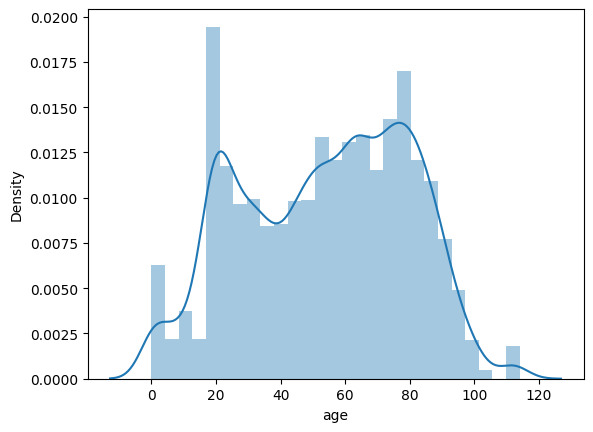

In [12]:
#载入seaborn库，查看数据分布
import seaborn as sns
from scipy import stats
Norm_age=stats.kstest(traindata.loc[:,'age'],cdf='norm')
print(Norm_age)
sns.distplot(traindata.loc[:,'age'])    #检测'Age'数据分布情况

/tmp/ipykernel_710/3443571005.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(traindata.loc[:,'gender_encode'],hist=True,kde=False,rug=True)    #显示性别分布情况


<Axes: xlabel='gender_encode'>

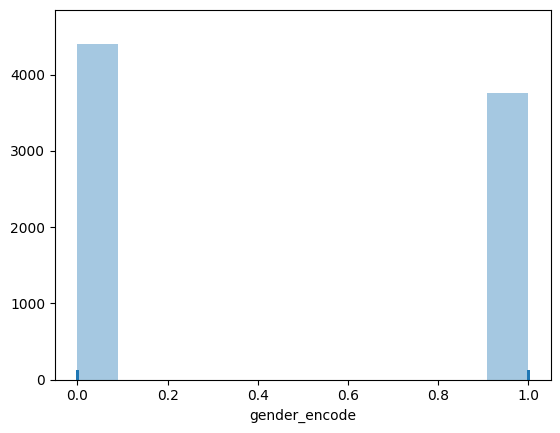

In [13]:
sns.distplot(traindata.loc[:,'gender_encode'],hist=True,kde=False,rug=True)    #显示性别分布情况

/tmp/ipykernel_710/682209176.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(traindata.loc[:,'disease_encode'],hist=True,kde=False,rug=True)    #显示疾病数据分布情况


<Axes: xlabel='disease_encode'>

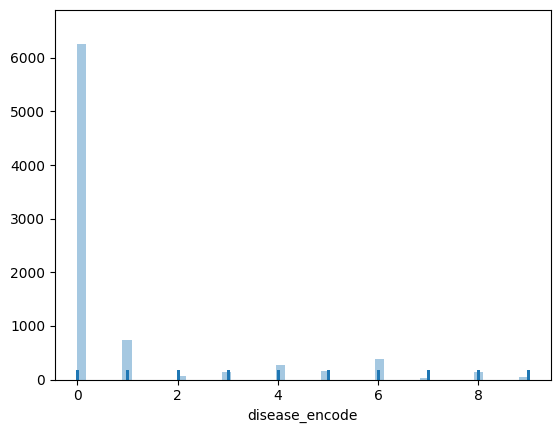

In [14]:
sns.distplot(traindata.loc[:,'disease_encode'],hist=True,kde=False,rug=True)    #显示疾病数据分布情况

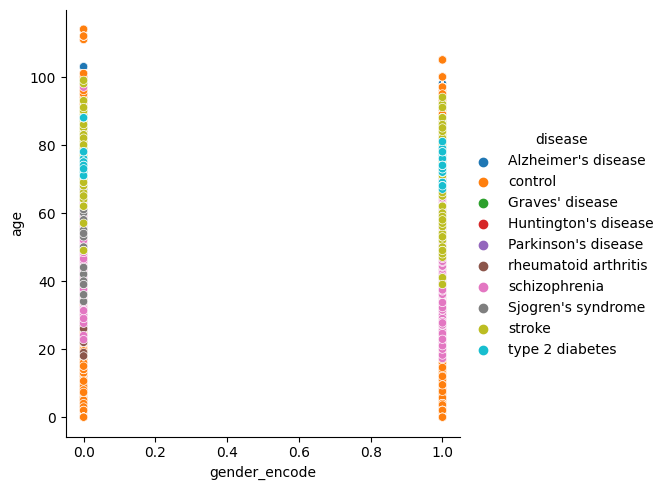

In [15]:
#显示疾病类型、性别和生物学年龄间的关系
sns.relplot(x='gender_encode',y='age',hue='disease',data=traindata)

/tmp/ipykernel_710/4287169906.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=traindata['age'],y=traindata['disease_encode'],shade=True)


<Axes: xlabel='age', ylabel='disease_encode'>

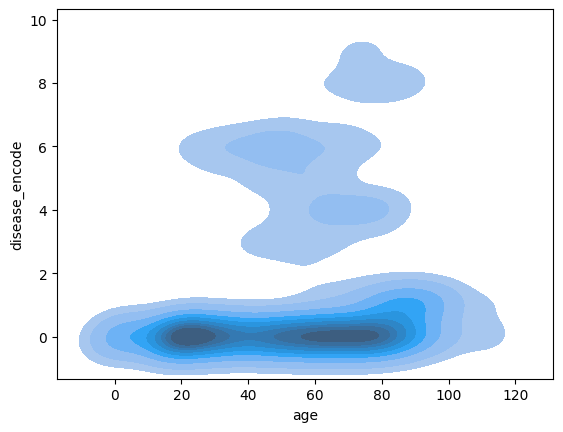

In [16]:
#显示生物学年龄与患病数据的核密度估计图
sns.kdeplot(x=traindata['age'],y=traindata['disease_encode'],shade=True)

先测试使用常规机器学习方法，这里使用XGBoost、CatBoost和Lightoom算法。

In [17]:
Data=traindata.iloc[:,1:-7]    #输入特征
Data['gender_encoder']=traindata.loc[:,'gender_encode']
target=traindata.loc[:,'age']    #输入特征
#分配训练、验证集和测试集
from sklearn.model_selection import train_test_split
Data_train,Data_test,Label_train,Label_test=train_test_split(Data,target,train_size=0.8,random_state=123)
print('训练集数据规模为:{0},测试集数据规模为:{1}'.format(Data_train.shape,Data_test.shape))
print('训练集标签规模为:{0},测试集标签规模为:{1}'.format(Label_train.shape,Label_test.shape)) 

训练集数据规模为:(6586, 50001),测试集数据规模为:(1647, 50001)
训练集标签规模为:(6586,),测试集标签规模为:(1647,)


In [19]:
#查看训练数据
Data_train.head(10)

cg00050873  cg00212031  cg00213748  cg00214611  cg00455876  cg01707559   
5344    0.000000    0.000000         0.0    0.000000    0.000000    0.000000  \
849     2.079779    0.000000         0.0    0.000000    0.000000    0.000000   
1296    0.000000    0.000000         0.0    0.000000    0.000000    0.000000   
5772    0.000000    0.000000         0.0    0.000000    0.000000    0.000000   
4512    0.000000    0.000000         0.0    0.000000    0.000000    0.000000   
5779    1.882748   -3.507691         0.0   -3.507691    0.000000   -2.648415   
6018    0.000000    0.000000         0.0    0.000000    0.000000    0.000000   
1071    0.000000    0.000000         0.0    0.000000    0.000000   -1.522701   
7778    1.606561   -1.152395         0.0   -3.744756    1.342748   -2.749976   
7897    1.814692   -3.659672         0.0   -2.985388    0.000000   -1.856830   

      cg02004872  cg02011394  cg02050847  cg02233190  ...  cg19326232   
5344    0.000000    0.000000    0.000000    0.000000  ...   -3.619579  \
849     0.000000    3.619579    0.000000    0.000000  ...   -4.247583   
1296    0.000000    0.000000    0.000000    0.000000  ...   -4.051632   
5772    0.000000    0.000000    0.000000    0.000000  ...   -4.178048   
4512    0.000000    0.000000    0.000000    0.000000  ...   -4.585271   
5779   -4.178048    3.124904    5.773449   -4.402578  ...   -4.247583   
6018    0.000000    0.000000    0.000000    0.000000  ...   -3.149987   
1071    0.000000    0.000000    0.000000    0.000000  ...   -3.938986   
7778   -4.807960    3.790034    4.247583   -3.837361  ...   -3.938986   
7897   -6.163916    2.985388    3.993781   -4.322159  ...   -3.507691   

      cg19331040  cg19342109  cg19343088  cg19343809  cg19348622  cg19349217   
5344   -3.149987    0.000000   -2.842141   -2.555085   -3.580953   -3.886935  \
849    -3.314031   -2.585369   -2.664729   -3.175661   -3.374769   -3.256540   
1296   -4.402578   -1.927076   -2.804368   -2.985388   -3.507691   -3.744756   
5772   -5.273603   -2.049755   -2.401172   -3.149987   -2.985388   -3.938986   
4512   -3.619579   -2.349789   -2.842141   -2.804368   -3.790034   -3.052934   
5779   -4.489850   -1.972920   -2.540233   -3.029956   -3.076403   -3.406479   
6018   -3.472874   -2.482634   -2.525567   -2.767818   -3.543689   -2.482634   
1071   -3.543689   -1.592260   -2.388119   -3.124904   -3.507691   -2.468664   
7778   -3.938986   -2.300497   -2.496772   -2.585369   -3.744756   -3.659672   
7897   -4.322159   -2.337277   -2.664729   -2.749976   -3.439160   -3.543689   

      cg19349369  cg19350197  gender_encoder  
5344   -4.178048    0.640954             0.0  
849    -2.174329    2.207487             0.0  
1296   -3.543689    0.502197             0.0  
5772   -4.489850    0.506456             0.0  
4512   -3.659672    0.875837             0.0  
5779   -3.201956    1.515914             1.0  
6018   -3.228904    1.398461             0.0  
1071   -1.918093    1.621000             0.0  
7778   -1.945225    2.540233             1.0  
7897   -4.112908    0.623305             1.0  

[10 rows x 50001 columns]

In [20]:
#加载并训练XGBoost模型
import xgboost
Model_XGB=xgboost.XGBRegressor(booster='gbtree',n_estimators=1000,max_depth=3,objective='reg:squarederror',gpu_id=0, tree_method='gpu_hist')
Model_XGB.fit(Data_train,Label_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
#评估模型训练效果，采用MAE
from sklearn.metrics import mean_squared_log_error,mean_absolute_error
train_mae=mean_absolute_error(Label_train,Model_XGB.predict(Data_train))
test_mae=mean_absolute_error(Label_test,Model_XGB.predict(Data_test))
print('训练MAE为:{0},测试MAE为:{1}'.format(round(train_mae,4),round(test_mae,4)))

训练MAE为:0.0539,测试MAE为:3.6546


<Axes: title={'center': 'Feature importance'}, xlabel='gain', ylabel='Features'>

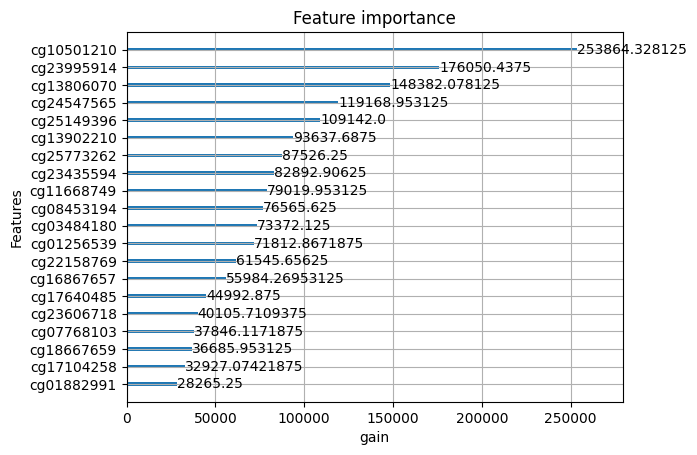

In [22]:
#提取贡献较大的前10个甲基化位点
from xgboost import plot_importance
plot_importance(Model_XGB,max_num_features=20,importance_type='gain',xlabel='gain')    #可视化前20个甲基化位点数据

In [23]:
#保存模型
import joblib
joblib.dump(Model_XGB,'Model_XGB.pkl')

['Model_XGB.pkl']

In [24]:
import xgboost as xgb  
Model_XGB.save_model('model_file_xgb.xgb')  # 参数 'model_file_name.xgb' 是你希望保存模型的路径和文件名

In [ ]:
pip install lightgbm

In [ ]:
pip install catboost

In [25]:
#分别训练CatBoost和lightgbm模型
import lightgbm as lgb
from catboost import CatBoostRegressor
Data_train_lgb=lgb.Dataset(Data_train,Label_train)
Data_test_lgb=lgb.Dataset(Data_test,Label_test)
params_lgb={
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'mae',
                'min_child_weight': 6,
                'num_leaves': 2 ** 6,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2023,
                'nthread' : 16,
                'verbose' : -1,
            }
Model_LGB=lgb.train(params_lgb,Data_train_lgb)

In [26]:
train_mae_lgb=mean_absolute_error(Label_train,Model_LGB.predict(Data_train))
test_mae_lgb=mean_absolute_error(Label_test,Model_LGB.predict(Data_test))
print('训练MAE为:{0},测试MAE为:{1}'.format(round(train_mae_lgb,4),round(test_mae_lgb,4)))

训练MAE为:0.6815,测试MAE为:3.3041


In [27]:
#保存模型
joblib.dump(Model_LGB,'Model_LGB.pkl')

['Model_LGB.pkl']

In [28]:
#训练catBoost模型
Model_Cat=CatBoostRegressor(learning_rate=0.5, depth=5, bootstrap_type='Bernoulli',
                            random_seed=2023,od_type='Iter', od_wait=100)
Model_Cat.fit(Data_train,Label_train)

947:	learn: 0.6152568	total: 24m 29s	remaining: 1m 20s
948:	learn: 0.6147318	total: 24m 31s	remaining: 1m 19s
949:	learn: 0.6144768	total: 24m 32s	remaining: 1m 17s
950:	learn: 0.6143754	total: 24m 34s	remaining: 1m 15s
951:	learn: 0.6121887	total: 24m 35s	remaining: 1m 14s
952:	learn: 0.6119358	total: 24m 37s	remaining: 1m 12s
953:	learn: 0.6112492	total: 24m 38s	remaining: 1m 11s
954:	learn: 0.6096319	total: 24m 40s	remaining: 1m 9s
955:	learn: 0.6089379	total: 24m 41s	remaining: 1m 8s
956:	learn: 0.6084943	total: 24m 43s	remaining: 1m 6s
957:	learn: 0.6084874	total: 24m 44s	remaining: 1m 5s
958:	learn: 0.6083819	total: 24m 46s	remaining: 1m 3s
959:	learn: 0.6081492	total: 24m 47s	remaining: 1m 2s
960:	learn: 0.6078731	total: 24m 49s	remaining: 1m
961:	learn: 0.6071073	total: 24m 51s	remaining: 58.9s
962:	learn: 0.6069580	total: 24m 52s	remaining: 57.3s
963:	learn: 0.6068692	total: 24m 54s	remaining: 55.8s
964:	learn: 0.6064321	total: 24m 55s	remaining: 54.2s
965:	learn: 0.6061711	to

In [29]:
train_mae_cat=mean_absolute_error(Label_train,Model_Cat.predict(Data_train))
test_mae_cat=mean_absolute_error(Label_test,Model_Cat.predict(Data_test))
print('训练MAE为:{0},测试MAE为:{1}'.format(round(train_mae_cat,4),round(test_mae_cat,4)))

训练MAE为:0.3313,测试MAE为:4.0189


In [30]:
joblib.dump(Model_Cat,'Model_Cat.pkl')

['Model_Cat.pkl']

In [32]:
#绘制CatBoost模型特征重要性评分
from pandas import DataFrame
Feature_importance_Cat=DataFrame()
Feature_importance_Cat['fearure names']=Data_train.columns    #特征列表
Feature_importance_Cat['fearure importance']=Model_Cat.get_feature_importance()    #特征重要性评分
Feature_importance_Cat=Feature_importance_Cat.sort_values('fearure importance',ascending=False)    #按照降序排序

In [33]:
Feature_importance_Cat.head(10)

fearure names  fearure importance
7938     cg10501210           16.818541
22071    cg18667659            8.234606
36195    cg23995914            6.687001
26829    cg07553761            6.650433
19945    cg12206199            5.950584
25883    cg03484180            4.685896
49102    cg16867657            4.374483
5115     cg04289036            3.456128
12908    cg21144922            2.386651
16825    cg02698806            2.082232

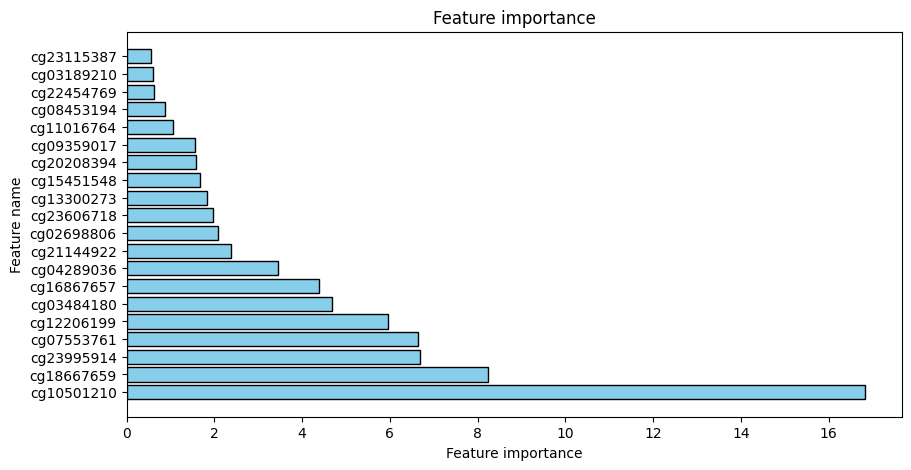

In [35]:
# 绘制CatBoost模型特征重要性柱形图
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.title('Feature importance')
plt.barh(np.arange(1,21), Feature_importance_Cat.iloc[:20,1],color='skyblue', edgecolor='black')
plt.ylabel('Feature name')  
plt.xlabel('Feature importance')
plt.yticks(np.arange(1,21),Feature_importance_Cat.iloc[:20,0])
plt.show()

绘制机器学习模型预测回归和残差数据

In [36]:
#加载XGBoost模型预测数据
from pandas import DataFrame
Train_label=DataFrame(Label_train)
Train_label['XGBoost_Pred']=Model_XGB.predict(Data_train)
Train_label['LightGM_Pred']=Model_LGB.predict(Data_train)
Train_label['CatBoost_Pred']=Model_Cat.predict(Data_train)
Train_label['Avg_Pred']=(Train_label['XGBoost_Pred']+Train_label['XGBoost_Pred']+Train_label['XGBoost_Pred'])/3

In [37]:
Train_label.head(10)

age  XGBoost_Pred  LightGM_Pred  CatBoost_Pred   Avg_Pred
5344  46.0000     46.098488     46.585196      45.027593  46.098492
849   90.0000     89.980980     88.959698      90.649812  89.980980
1296  78.6000     78.683403     79.022301      78.810803  78.683403
5772  86.0000     85.985695     85.281214      86.393603  85.985695
4512  31.7123     31.696819     31.446005      31.730395  31.696817
5779  86.1000     86.071365     85.415275      86.037929  86.071373
6018  74.0000     73.986374     72.909071      73.769591  73.986374
1071  93.0000     92.997696     93.489377      93.329740  92.997704
7778  81.2110     81.213722     80.956693      81.384063  81.213722
7897  41.9000     41.953110     42.934054      41.608917  41.953110

In [38]:
#自动计算回归方程和R2值的函数
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
def Reg_plot(x,y,data):
    y_pred=np.array(data.loc[:,x]).reshape(-1,1)    #获取预测数据
    y_true=np.array(data.loc[:,y]).reshape(-1,1)    #获取真实数据
    Model_Reg=LinearRegression()
    Model_Reg.fit(y_pred,y_true)
    coef=Model_Reg.coef_    #回归方程系数
    intercept=Model_Reg.intercept_    #计算回归方程截距
    R2_value=r2_score(y_true,y_pred)    #计算R2值
    print('回归系数为:',coef)
    print('回归方程截距为:',intercept)
    print('R2值为:',R2_value)
    sns.regplot(x=x,y=x,data=data)    #绘制回归图

回归系数为: [[1.0001178]]
回归方程截距为: [-0.00631332]
R2值为: 0.999747840708575


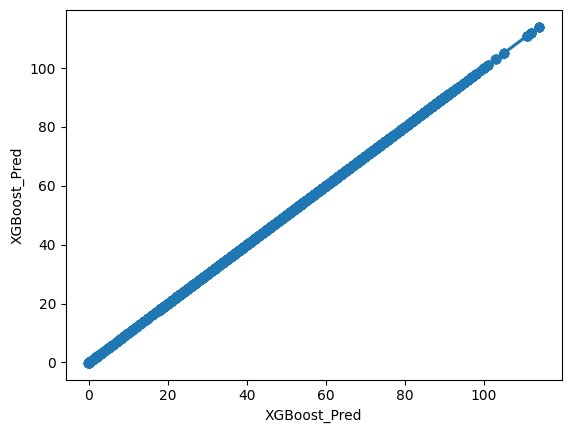

In [39]:
Reg_plot(x='XGBoost_Pred',y='age',data=Train_label)    #绘制XGBoost模型训练回归图

回归系数为: [[1.00556175]]
回归方程截距为: [-0.29445444]
R2值为: 0.9978368581311565


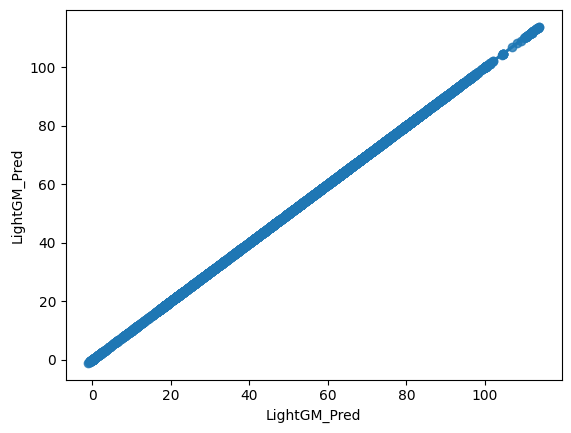

In [40]:
Reg_plot(x='LightGM_Pred',y='age',data=Train_label)    #绘制lightGM模型训练回归图

回归系数为: [[1.00074494]]
回归方程截距为: [-0.03991243]
R2值为: 0.9994725603375314


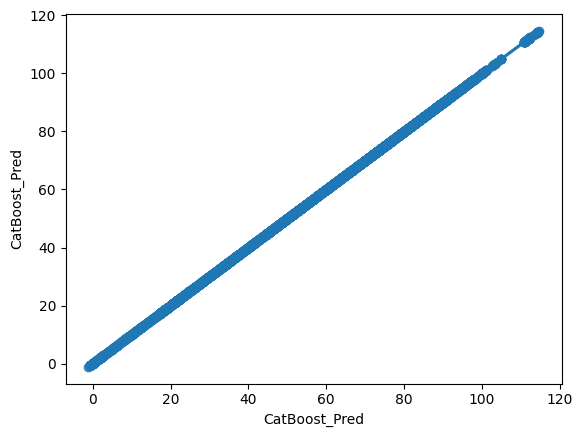

In [41]:
Reg_plot(x='CatBoost_Pred',y='age',data=Train_label)    #绘制Catboost模型训练回归图

回归系数为: [[1.0001178]]
回归方程截距为: [-0.00631332]
R2值为: 0.9997478407030478


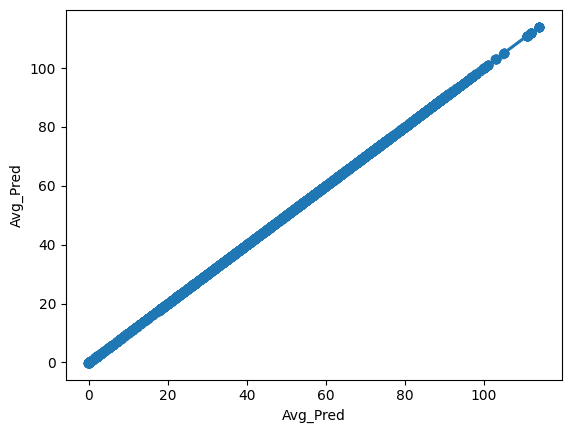

In [42]:
Reg_plot(x='Avg_Pred',y='age',data=Train_label)    #绘制均值训练回归图

In [43]:
#残差计算和绘制函数
def Resid_plot(x,y,data):
    y_pred=np.array(data.loc[:,x]).reshape(-1,1)    #获取预测数据
    y_true=np.array(data.loc[:,y]).reshape(-1,1)    #获取真实数据
    Resid=y_true-y_pred    #计算残差
    Resid_Mean=np.mean(Resid)    ##计算平均残差
    print('平均残差为:',Resid_Mean)
    sns.residplot(x=x,y=y,data=data)    #绘制残差图

平均残差为: 2.8035592858485467e-06


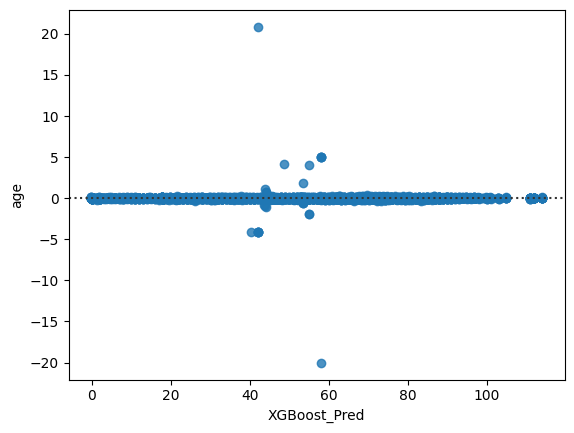

In [44]:
Resid_plot(x='XGBoost_Pred',y='age',data=Train_label)    #绘制XGBoost模型训练残差图

平均残差为: 0.0037495625072935922


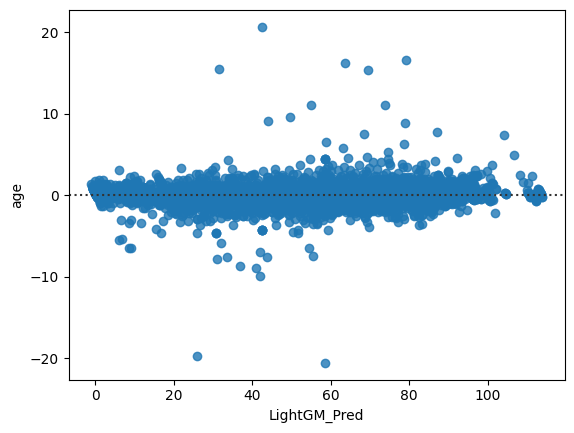

In [45]:
Resid_plot(x='LightGM_Pred',y='age',data=Train_label)    #绘制lightGM模型训练残差图

平均残差为: 3.155410906728972e-05


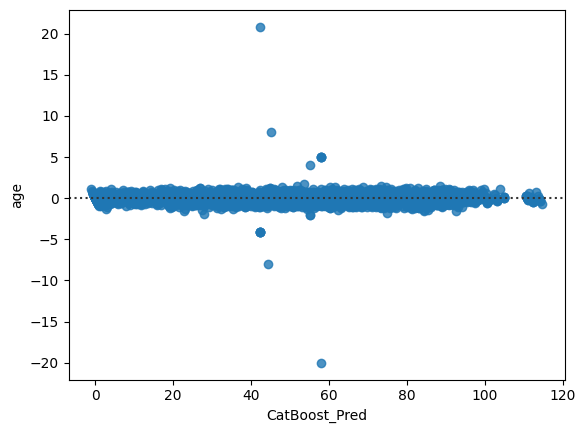

In [46]:
Resid_plot(x='CatBoost_Pred',y='age',data=Train_label)    #绘制Catboost模型训练残差图

平均残差为: 2.801286968712325e-06


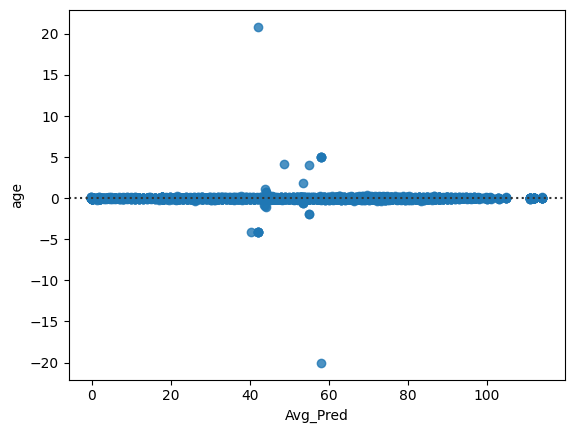

In [47]:
Resid_plot(x='Avg_Pred',y='age',data=Train_label)    #绘制均值数据训练残差图

绘制机器学习模型预测测试数据回归和残差图

In [48]:
#加载XGBoost模型预测数据
from pandas import DataFrame
Test_label=DataFrame(Label_test)
Test_label['XGBoost_Pred']=Model_XGB.predict(Data_test)
Test_label['LightGM_Pred']=Model_LGB.predict(Data_test)
Test_label['CatBoost_Pred']=Model_Cat.predict(Data_test)
Test_label['Avg_Pred']=(Test_label['XGBoost_Pred']+Test_label['XGBoost_Pred']+Test_label['XGBoost_Pred'])/3

In [49]:
Test_label.head(10)

age  XGBoost_Pred  LightGM_Pred  CatBoost_Pred   Avg_Pred
3328  18.0000     15.477611     20.067208      18.202026  15.477611
3525  30.0000     30.041004     32.349675      30.291573  30.041006
1980  18.5205     18.510391     20.700402      19.608212  18.510391
3846  68.0000     68.005966     67.187684      68.530502  68.005966
5379  68.0000     73.031631     73.882840      67.624679  73.031631
514   81.0000     88.601585     86.399964      91.527821  88.601585
4778  23.2603     23.274717     23.417180      23.340527  23.274717
7941  45.6800     51.424107     46.402251      40.092550  51.424107
8183  79.0000     80.507607     78.908942      78.127226  80.507607
1193  95.0000     88.560379     88.440900      87.609112  88.560387

回归系数为: [[0.98916155]]
回归方程截距为: [0.5641136]
R2值为: 0.9387928099557166


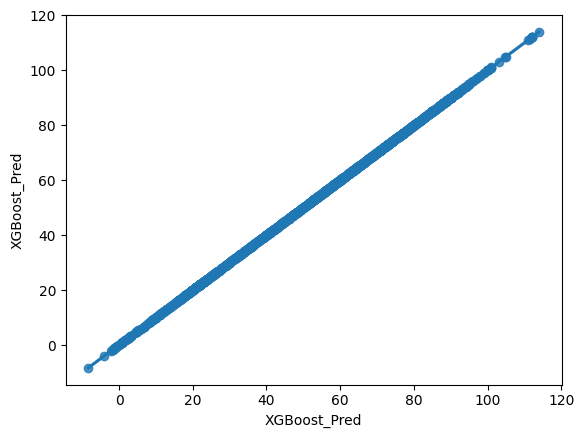

In [50]:
Reg_plot(x='XGBoost_Pred',y='age',data=Test_label)    #绘制XGBoost模型测试回归图

回归系数为: [[1.0158234]]
回归方程截距为: [-0.74942732]
R2值为: 0.9543730415616548


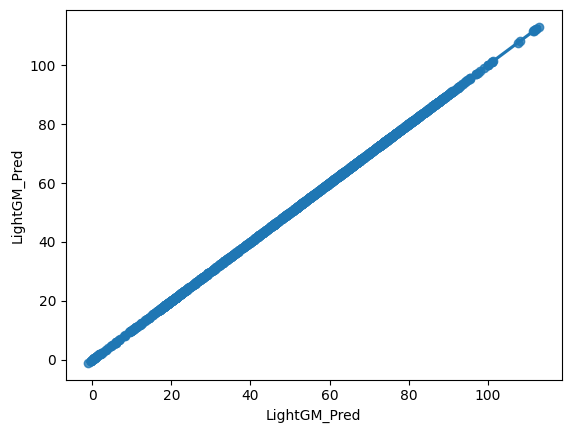

In [51]:
Reg_plot(x='LightGM_Pred',y='age',data=Test_label)    #绘制LightGM模型测试回归图

回归系数为: [[0.97434014]]
回归方程截距为: [1.45470374]
R2值为: 0.9327645551961626


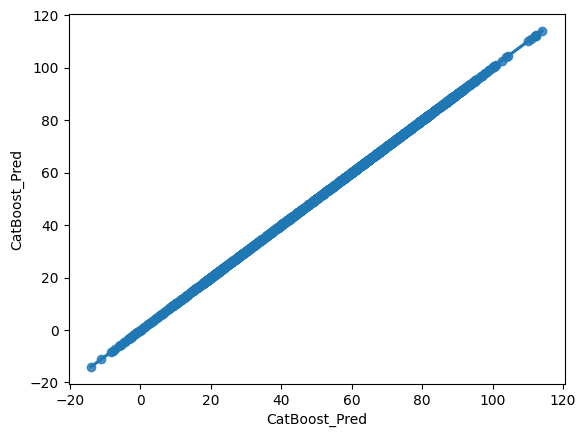

In [52]:
Reg_plot(x='CatBoost_Pred',y='age',data=Test_label)    #绘制CatBoost模型测试回归图

回归系数为: [[0.98916155]]
回归方程截距为: [0.5641136]
R2值为: 0.9387928100823165


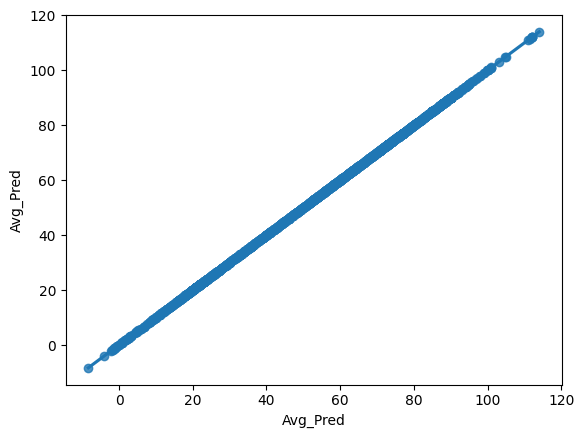

In [53]:
Reg_plot(x='Avg_Pred',y='age',data=Test_label)    #绘制均值模型测试回归图

平均残差为: -0.019381291550194215


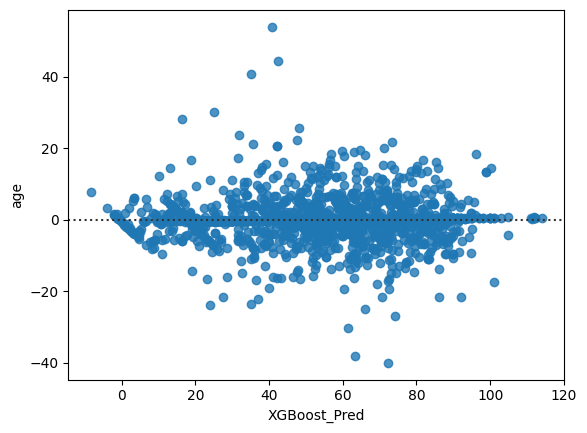

In [54]:
Resid_plot(x='XGBoost_Pred',y='age',data=Test_label)    #绘制XGBoost模型测试残差图

平均残差为: 0.10053161812102236


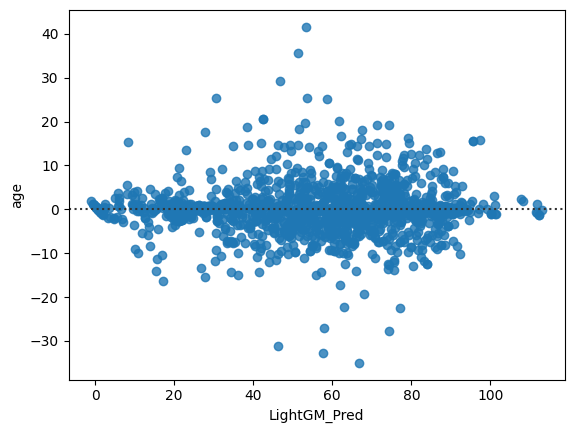

In [55]:
Resid_plot(x='LightGM_Pred',y='age',data=Test_label)    #绘制lightGM模型测试残差图

平均残差为: 0.07574010629655892


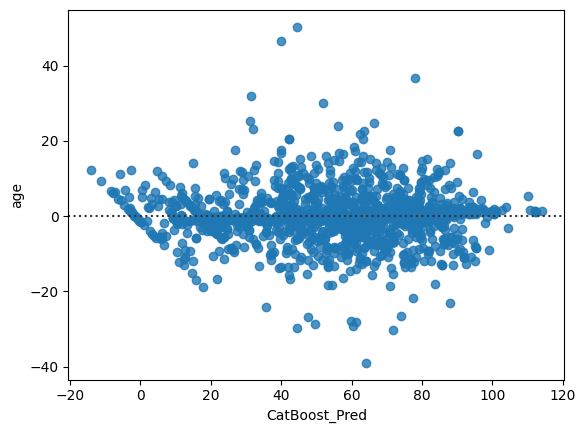

In [56]:
Resid_plot(x='CatBoost_Pred',y='age',data=Test_label)    #绘制Catboost模型测试残差图

平均残差为: -0.019381350193546715


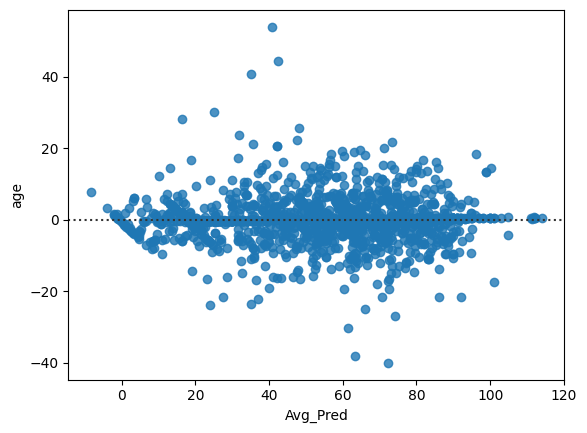

In [57]:
Resid_plot(x='Avg_Pred',y='age',data=Test_label)    #绘制均值测试数据残差图

加载SHAP模块解释特征

In [12]:
import joblib
Model_LGB=joblib.load('/mnt/workspace/CNN_Note/Models_Regressior/Model_LGB.pkl')

In [58]:
#LightGM模型表现最优，因此我们使用LightGM模型的特征重要性评分作为SHAP评分系统
from pandas import DataFrame
Feature_importance=DataFrame()
Feature_importance['fearure names']=Data_train.columns    #特征列表
Feature_importance['fearure importance']=Model_LGB.feature_importance()    #特征重要性评分
Feature_importance=Feature_importance.sort_values('fearure importance',ascending=False)    #按照降序排序

In [59]:
Feature_importance.head(10)

fearure names  fearure importance
49102    cg16867657                 141
23802    cg23606718                  43
23955    cg24079702                  40
26829    cg07553761                  36
23345    cg22454769                  26
46158    cg08453194                  18
42614    cg25090514                  16
11092    cg17104258                  16
36195    cg23995914                  15
28027    cg12934382                  15

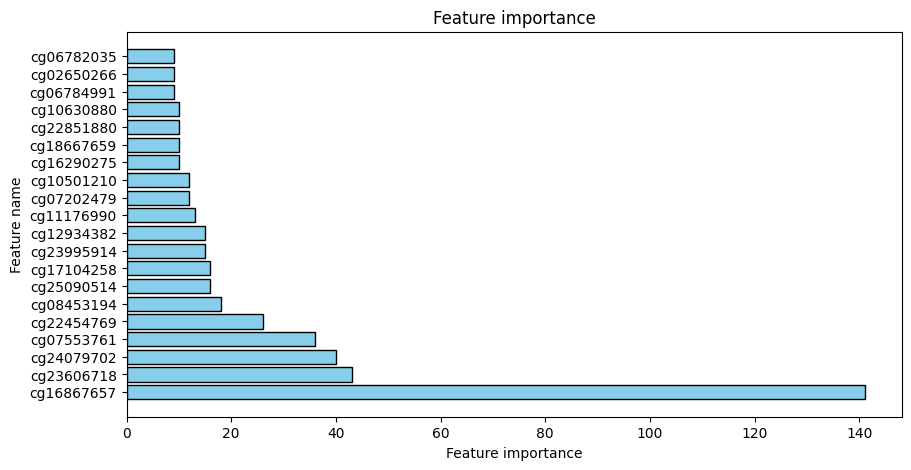

In [61]:
# 绘制LightGM模型特征重要性柱形图
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.title('Feature importance')
plt.barh(np.arange(1,21), Feature_importance.iloc[:20,1],color='skyblue', edgecolor='black')
plt.ylabel('Feature name')  
plt.xlabel('Feature importance')
plt.yticks(np.arange(1,21),Feature_importance.iloc[:20,0])
plt.show()

提取前20个标签数据训练LightGm模型用于SHAP处理

In [63]:
LightGM_label=list(Feature_importance.iloc[:20,0])
LightGM_Data=traindata.loc[:,LightGM_label]
LGM_traindata,LGM_testdata,LGM_trainlabel,LGM_testlabel=train_test_split(LightGM_Data,target,train_size=0.8,random_state=123)
print('训练集数据规模为:{0},测试集数据规模为:{1}'.format(LGM_traindata.shape,LGM_testdata.shape))
print('训练集标签规模为:{0},测试集标签规模为:{1}'.format(LGM_trainlabel.shape,LGM_testlabel.shape)) 

训练集数据规模为:(6586, 20),测试集数据规模为:(1647, 20)
训练集标签规模为:(6586,),测试集标签规模为:(1647,)


In [64]:
import lightgbm as lgb
train_lgb=lgb.Dataset(LGM_traindata,LGM_trainlabel)
test_lgb=lgb.Dataset(LGM_testdata,LGM_testlabel)
params_lgb_shap={
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'mae',
                'min_child_weight': 6,
                'num_leaves': 2 ** 6,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2023,
                'nthread' : 16,
                'verbose' : -1,
            }
Model_LGB_shap=lgb.train(params_lgb_shap,train_lgb)

In [65]:
from sklearn.metrics import mean_absolute_error
trainmae_lgb=mean_absolute_error(LGM_trainlabel,Model_LGB_shap.predict(LGM_traindata))
testmae_lgb=mean_absolute_error(LGM_testlabel,Model_LGB_shap.predict(LGM_testdata))
print('训练MAE为:{0},测试MAE为:{1}'.format(round(trainmae_lgb,4),round(testmae_lgb,4)))

训练MAE为:2.2863,测试MAE为:3.9281


In [67]:
joblib.dump(trainmae_lgb,'trainmae_lgb_shap.pkl')

['trainmae_lgb_shap.pkl']

训练集SHAP分析

In [68]:
import shap
Explainer=shap.TreeExplainer(Model_LGB_shap)    #创建解释器
shap_values=Explainer.shap_values(LGM_traindata)    #计算训练shap值

In [69]:
shap.initjs()
shap.force_plot(Explainer.expected_value,shap_values[0,:],LGM_traindata.iloc[0,:])

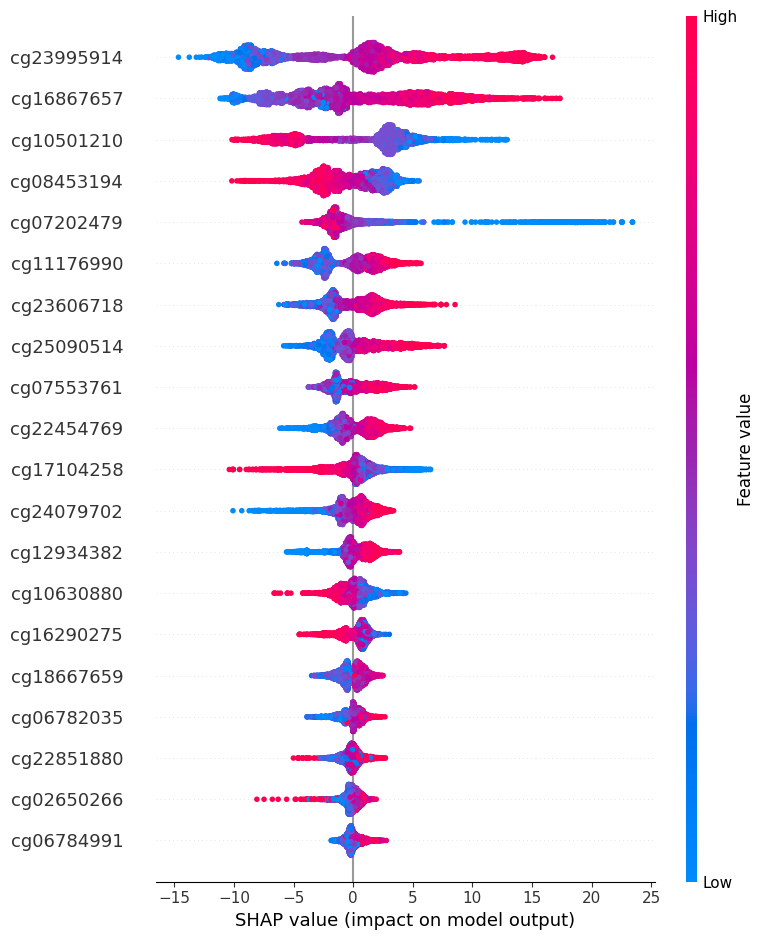

In [70]:
shap.summary_plot(shap_values,LGM_traindata)    #全局特征SHAP分布(训练)

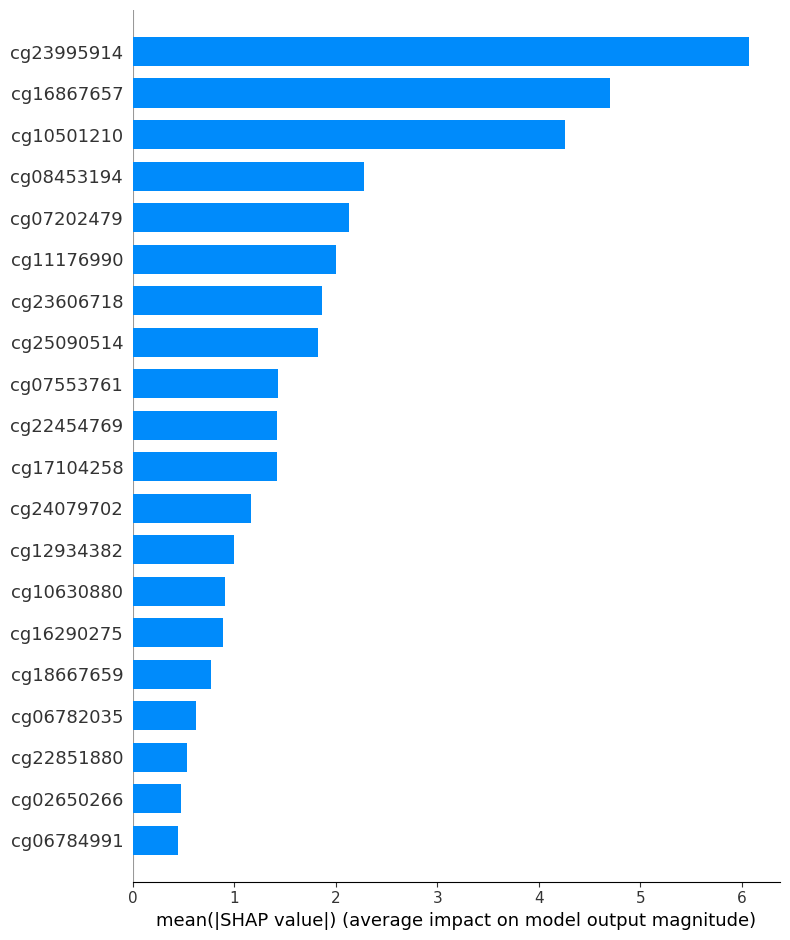

In [71]:
shap.summary_plot(shap_values,LGM_traindata,plot_type='bar')    #特征重要性堆叠图(训练)

测试集SHAP分析

In [72]:
Explainer_test=shap.TreeExplainer(Model_LGB_shap)    #创建解释器
shap_values_test=Explainer_test.shap_values(LGM_testdata)    #计算测试shap值

In [73]:
shap.initjs()
shap.force_plot(Explainer_test.expected_value,shap_values_test[0,:],LGM_testdata.iloc[0,:])

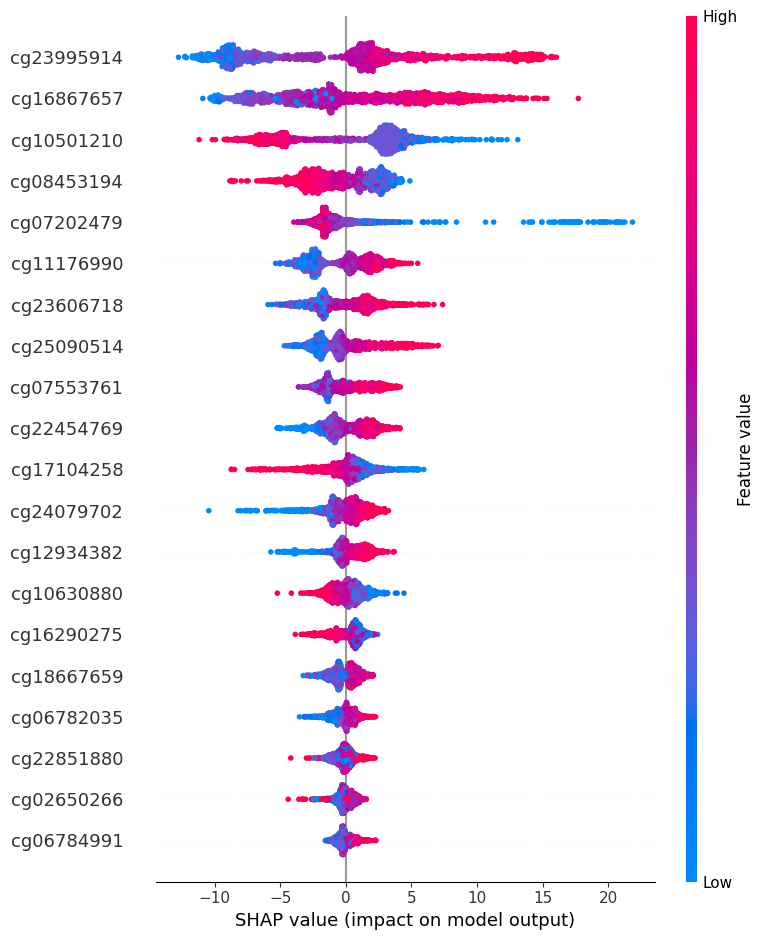

In [74]:
shap.summary_plot(shap_values_test,LGM_testdata)    #全局特征SHAP分布(测试)

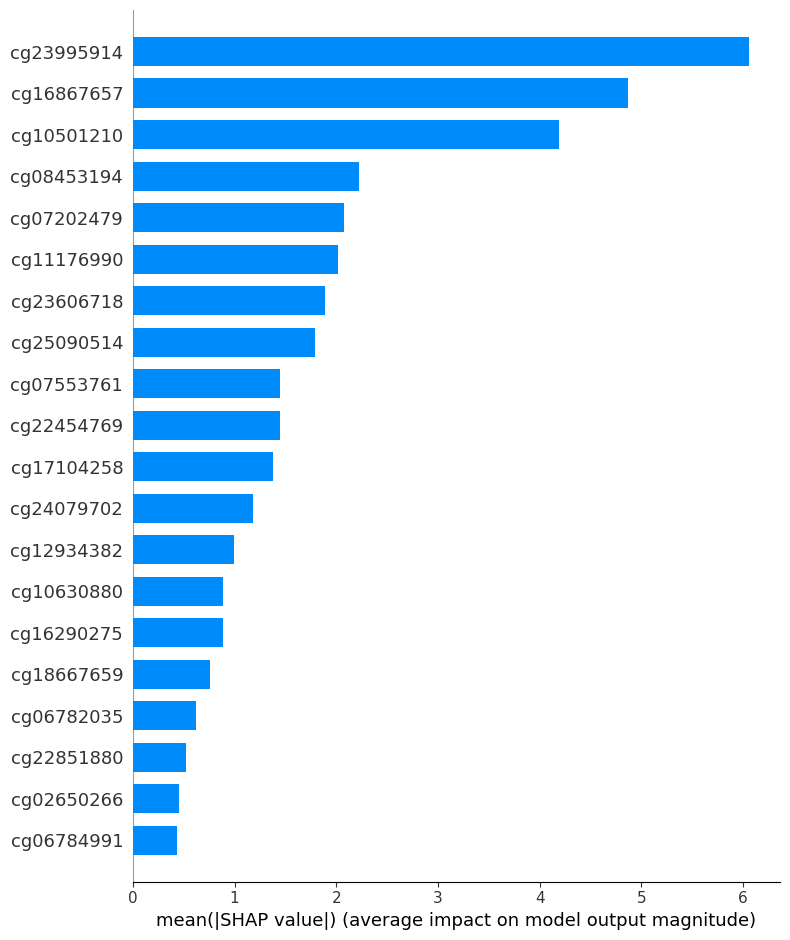

In [75]:
shap.summary_plot(shap_values_test,LGM_testdata,plot_type='bar')    #特征重要性堆叠图(测试)

经过以上步骤已经完成对数据的预处理工作，接下来主要进行数据切分、构建数据输入管道、建立深度神经网络和训练，最后评估神经网络模型效果。在这里，预测生物学年龄属于回归任务，甲基化数据较多；因此选择构建一维卷积神经网络，采用MAE评估模型训练效果.

In [ ]:
#数据特征降维
from sklearn.decomposition import PCA
Train_Data=traindata.iloc[:,1:-5]    #输入特征
pca=PCA(n_components=0.95)
Data_pca=pca.fit_transform(Train_Data)

In [ ]:
#计算斯皮尔曼相关性
from pandas import DataFrame
from scipy.stats import spearmanr
Corr,P_value=spearmanr(Data_pca,traindata.loc[:,'age'])
Corr=DataFrame(Corr)
P_value=DataFrame(P_value)

In [ ]:
#数据集切分
Train_Data=traindata.iloc[:,1:-4]    #输入特征
#Train_Data['sample_type']=traindata.loc[:,'sample_type']
#Train_Data['gender']=traindata.loc[:,'gender']
Train_target=traindata.loc[:,'age']    #输入特征
#分配训练、验证集和测试集
from sklearn.model_selection import train_test_split
Data_train,X_test,Target_train,y_test=train_test_split(Train_Data,Train_target,train_size=0.8,random_state=123)    #X表示数据输入特征，y表示数据标签，即生物学年龄
X_train=Data_train[:5000]    #划分训练数据和转化格式
X_train=np.array(X_train).reshape(X_train.shape[0],X_train.shape[1],1)
y_train=Target_train[:5000]
X_valid=Data_train[5000:]    #划分验证数据并转化格式
X_valid=np.array(X_valid).reshape(X_valid.shape[0],X_valid.shape[1],1)
y_valid=Target_train[5000:]
X_test=np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],1)
print('训练集数据规模为:{0},验证集数据规模为:{1},测试集数据规模为:{2}'.format(X_train.shape,X_valid.shape,X_test.shape))
print('训练集标签规模为:{0},验证集标签规模为:{1},测试集标签规模为:{2}'.format(y_train.shape,y_valid.shape,y_test.shape))

In [ ]:
#构建数据输入流
Train_Input=tf.data.Dataset.from_tensor_slices((X_train,y_train)).repeat(1)    #训练数据集
Train_Input=Train_Input.shuffle(buffer_size=1000,seed=123)
Train_Input=Train_Input.batch(10).prefetch(tf.data.experimental.AUTOTUNE)
Valid_Input=tf.data.Dataset.from_tensor_slices((X_valid,y_valid)).repeat(1)    #验证数据集
Valid_Input=Valid_Input.shuffle(buffer_size=1000,seed=123)
Valid_Input=Valid_Input.batch(10).prefetch(tf.data.experimental.AUTOTUNE)
Test_Input=tf.data.Dataset.from_tensor_slices((X_test,y_test)).repeat(1)    #测试数据集
Test_Input=Test_Input.shuffle(buffer_size=1000,seed=123)
Test_Input=Test_Input.batch(10).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
#模型组网
from tensorflow import keras
CNN_Net=keras.models.Sequential()
CNN_Net.add(keras.layers.InputLayer(input_shape=(40000,1),name='Input_Layrt'))
for rate in (1,2,4,8,16)*2:    #CNN层
    CNN_Net.add(keras.layers.Conv1D(filters=500,kernel_size=2,padding='valid',activation='relu',dilation_rate=rate))
    CNN_Net.add(keras.layers.AveragePooling1D(2))    
CNN_Net.add(keras.layers.Conv1D(filters=250,kernel_size=2,padding='valid',activation='relu'))
for rate in (1,2,4,8,16)*2:    #LSTM层
    CNN_Net.add(keras.layers.LSTM(250,return_sequences=True))
CNN_Net.add(keras.layers.LSTM(250,return_sequences=False))
CNN_Net.add(keras.layers.Flatten())
CNN_Net.add(keras.layers.Dropout(rate=0.3))
CNN_Net.add(keras.layers.Dense(100,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),kernel_constraint=keras.constraints.max_norm(1)))
CNN_Net.add(keras.layers.Dense(100,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),kernel_constraint=keras.constraints.max_norm(1)))
CNN_Net.add(keras.layers.BatchNormalization())
CNN_Net.add(keras.layers.Dropout(rate=0.3))
CNN_Net.add(keras.layers.Dense(50,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),kernel_constraint=keras.constraints.max_norm(1)))
CNN_Net.add(keras.layers.Dropout(rate=0.3))
CNN_Net.add(keras.layers.Dense(25,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),kernel_constraint=keras.constraints.max_norm(1)))
CNN_Net.add(keras.layers.Dropout(rate=0.3))
CNN_Net.add(keras.layers.Dense(15,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),kernel_constraint=keras.constraints.max_norm(1)))
CNN_Net.add(keras.layers.BatchNormalization())
CNN_Net.add(keras.layers.Dense(5,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),kernel_constraint=keras.constraints.max_norm(1)))
CNN_Net.add(keras.layers.Dense(1,name='output_layer'))
CNN_Net.summary()

构建CNN-LSTM-AVE结构编解码器

In [ ]:
#构建自采样层
K=keras.backend
class Sampling(keras.layers.Layer):
    def call(self,inputs):
        mean,var_log=inputs
        return K.random.normal(tf.shape(var_log))*K.exp(var_log/2)+mean

In [ ]:
#构建编码器
conding_size=10
Input=keras.layers.InputLayer(input_shape=(40000,1),name='Input_Layrt')    #输入层
Conv_layer=keras.layers.Conv1D(filters=500,kernel_size=2,padding='valid',activation='relu',dilation_rate=1)(Conv_layer)    #CNN模块
Conv_layer=keras.layers.AveragePooling1D(2)(Conv_layer)
Conv_layer=keras.layers.Conv1D(filters=500,kernel_size=2,padding='valid',activation='relu',dilation_rate=2)(Conv_layer)
Conv_layer=keras.layers.AveragePooling1D(2)(Conv_layer)
Conv_layer=keras.layers.Conv1D(filters=500,kernel_size=2,padding='valid',activation='relu',dilation_rate=4)(Conv_layer)
Conv_layer=keras.layers.AveragePooling1D(2)(Conv_layer)
Conv_layer=keras.layers.Conv1D(filters=500,kernel_size=2,padding='valid',activation='relu',dilation_rate=8)(Conv_layer)
Conv_layer=keras.layers.AveragePooling1D(2)(Conv_layer)
Conv_layer=keras.layers.Conv1D(filters=500,kernel_size=2,padding='valid',activation='relu',dilation_rate=16)(Conv_layer)
Conv_layer=keras.layers.AveragePooling1D(2)(Conv_layer)
Conv_layer=keras.layers.Conv1D(filters=250,kernel_size=2,padding='valid',activation='relu')(Conv_layer)
LSTM_layer=keras.layers.LSTM(250,return_sequences=True)(Conv_layer)    #LSTM模块
LSTM_layer=keras.layers.LSTM(250,return_sequences=True)(LSTM_layer)
LSTM_layer=keras.layers.LSTM(250,return_sequences=True)(LSTM_layer)
LSTM_layer=keras.layers.LSTM(250,return_sequences=True)(LSTM_layer)
LSTM_layer=keras.layers.LSTM(250,return_sequences=True)(LSTM_layer)
LSTM_layer=keras.layers.LSTM(250,return_sequences=False)(LSTM_layer)
Flatten_layer=keras.layers.Flatten()(LSTM_layer)    #Dense模块
Dense_layer=keras.layers.Dense(100,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),
                   kernel_constraint=keras.constraints.max_norm(1))(Flatten_layer)
Dense_layer=keras.layers.Dense(50,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),
                   kernel_constraint=keras.constraints.max_norm(1))(Dense_layer)
Dense_layer=keras.layers.Dense(25,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),
                   kernel_constraint=keras.constraints.max_norm(1))(Dense_layer)
Dense_layer=keras.layers.Dense(15,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),
                   kernel_constraint=keras.constraints.max_norm(1))(Dense_layer)
Dense_layer=keras.layers.Dense(10,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),
                   kernel_constraint=keras.constraints.max_norm(1))(Dense_layer)
Conding_mean=keras.layers.Dense(conding_size)(Dense_layer)    #均值数据
Conding_var_log=keras.layers.Dense(conding_size)(Dense_layer)    #对数标准差数据
Conding=Sampling()([Conding_mean,Conding_var_log])    #编码数据
AVE_Encoder=keras.Model(inputs=[Input],outputs=[Conding_mean,Conding_var_log,Conding])    #编码器构建

In [ ]:
#构建解码器
Input_Dencoder=keras.Input(shape=[conding_size])
Dense_layer_Dncoder=keras.layers.Dense(10,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),
                   kernel_constraint=keras.constraints.max_norm(1))(Input_Dencoder)
Dense_layer_Dncoder=keras.layers.Dense(15,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),
                   kernel_constraint=keras.constraints.max_norm(1))(Dense_layer_Dncoder)
Dense_layer_Dncoder=keras.layers.Dense(25,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),
                   kernel_constraint=keras.constraints.max_norm(1))(Dense_layer_Dncoder)
Dense_layer_Dncoder=keras.layers.Dense(50,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),
                   kernel_constraint=keras.constraints.max_norm(1))(Dense_layer_Dncoder)
Dense_layer_Dncoder=keras.layers.Dense(100,activation='selu',kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l1_l2(0.01,0.01),
                   kernel_constraint=keras.constraints.max_norm(1))(Dense_layer_Dncoder)
LSTM_layer_Dncoder=keras.layers.RepeatVector(100)(Dense_layer_Dncoder)        #LSTM模块
LSTM_layer_Dncoder=keras.layers.LSTM(250,return_sequences=True)(LSTM_layer_Dncoder)
LSTM_layer_Dncoder=keras.layers.LSTM(250,return_sequences=True)(LSTM_layer_Dncoder)
LSTM_layer_Dncoder=keras.layers.LSTM(250,return_sequences=True)(LSTM_layer_Dncoder)
LSTM_layer_Dncoder=keras.layers.LSTM(250,return_sequences=True)(LSTM_layer_Dncoder)
LSTM_layer_Dncoder=keras.layers.LSTM(250,return_sequences=True)(LSTM_layer_Dncoder)
LSTM_layer_Dncoder=keras.layers.LSTM(250,return_sequences=False)(LSTM_layer_Dncoder) 
Conv_layer_Dncoder=keras.Conv1DTranspose(filters=250,kernel_size=2,padding='valid',activation='relu',dilation_rate=16)(LSTM_layer_Dncoder)    #CNN模块
Conv_layer_Dncoder=keras.Conv1DTranspose(filters=500,kernel_size=2,padding='valid',activation='relu',dilation_rate=16)(Conv_layer_Dncoder)
Conv_layer_Dncoder=keras.Conv1DTranspose(filters=500,kernel_size=2,padding='valid',activation='relu',dilation_rate=16)(Conv_layer_Dncoder)
Conv_layer_Dncoder=keras.Conv1DTranspose(filters=500,kernel_size=2,padding='valid',activation='relu',dilation_rate=16)(Conv_layer_Dncoder)
Conv_layer_Dncoder=keras.Conv1DTranspose(filters=500,kernel_size=2,padding='valid',activation='relu',dilation_rate=16)(Conv_layer_Dncoder)
Conv_layer_Dncoder=keras.Conv1DTranspose(filters=500,kernel_size=2,padding='valid',dilation_rate=16)(Conv_layer_Dncoder)
Out_layer_Dncoder=keras.layers.Reshape([40000,1])
AVE_Dncoder=keras.Model(inputs=[Input_Dencoder],outputs=[Out_layer_Dncoder])    #解码器构建

In [ ]:
#编解码器组装
Conding_mean,Conding_var_log,Conding=AVE_Encoder(inputs)
Reconstructions=AVE_Dncoder(Conding)
CNN_LSTM_AVE=keras.Model(inputs=[inputs],outputs=[Reconstructions]) 

In [ ]:
#添加额外损失
latent_loss=-0.5*K.sum(1+Conding_var_log-K.exp(Conding_var_log)-K.square(Conding_mean),axis=-1)
CNN_LSTM_AVE.add(K.mean(latent_loss)/40000)

In [ ]:
#模型编译及训练
train_epochs=40
lr_scheduler=keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=20)    #学习率性能调度
CheckPoint_model=keras.callbacks.ModelCheckpoint('CNN_Net',save_best_only=True)    #设置提前停止
EarlyStopping_model=keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)
CNN_Net.compile(loss='MAE',optimizer=keras.optimizers.Nadam(lr=0.001),metrics=['MAE'])
CNN_Net_history=CNN_Net.fit(Train_Input,epochs=train_epochs,validation_data=Valid_Input,verbose=1,callbacks=[lr_scheduler,CheckPoint_model,EarlyStopping_model])

In [ ]:
#绘制训练参数图
from pandas import DataFrame
import matplotlib.pyplot as plt
Train_history=DataFrame(CNN_Net_history.history)
fig9=plt.figure(figsize=(12,12))
ax91=fig9.add_subplot(211)
ax91.set_title('MAE Curve')
plt.grid(color='black',linestyle='-.',alpha=0.3)
ax91.plot(np.arange(1,Train_history.shape[0]+1),Train_history.loc[:,'MAE'],color='orange',label='MSE')
ax91.plot(np.arange(1,Train_history.shape[0]+1),Train_history.loc[:,'val_MAE'],color='blue',label='val_MSE')
ax91.plot(np.arange(1,Train_history.shape[0]+1),Train_history.loc[:,'lr'],color='green',label='lr')
ax91.set_xlabel('train eopchs')
ax91.set_ylabel('MAE')
plt.legend()
plt.show()
fig10=plt.figure(figsize=(12,12))
ax10=fig10.add_subplot(211)
ax10.set_title('Loss Curve')
plt.grid(color='black',linestyle='-.',alpha=0.3)
ax10.plot(np.arange(1,Train_history.shape[0]+1),Train_history.loc[:,'loss'],color='orange',label='loss')
ax10.plot(np.arange(1,Train_history.shape[0]+1),Train_history.loc[:,'val_loss'],color='blue',label='val_loss')
ax10.set_xlabel('train eopchs')
ax10.set_ylabel('loss')
plt.legend()
plt.show()

In [ ]:
CNN_Net.evaluate(Test_Input)    #评估模型结果

In [ ]:
#保存模型
CNN_Net.save('CNN_Net.h5')

完成深度学习模型的训练和评估工作后，根据要求完成测试数据推理工作并输出

推理数据集读取与预处理

In [ ]:
import pandas as pd
import numpy as np
testdata = pd.read_csv('/mnt/workspace/Data/ai4bio_testset_final/testdata.csv', nrows=40000)    #读取测试集
testmap = pd.read_csv('/mnt/workspace/Data/ai4bio_testset_final/testmap.csv')
#预处理测试集
testdata = testdata.set_index('cpgsite')
testdata = testdata.T
testdata = testdata.reset_index()
testdata = testdata.rename(columns={'index':'sample_id'})
testdata.columns = ['sample_id'] + [i for i in range(40000)]
testdata.to_pickle('/mnt/workspace/CNN_Note/testdata_3.pkl')
testmap = pd.read_csv('/mnt/workspace/Data/ai4bio_testset_final/testmap.csv')
testdata = pd.read_pickle('/mnt/workspace/CNN_Note/testdata_3.pkl')

In [ ]:
testdata.fillna(0,inplace=True)    #预处理测试集
testdata = testdata.merge(testmap[['sample_id', 'gender']],on='sample_id',how='left')

In [ ]:
#测试集转化
gender_mapping = {'F': 0, 'M': 1}
testdata['gender'] = testdata['gender'].map(gender_mapping)

In [ ]:
testdata.head(10)

深度学习推理模块

In [ ]:
#重构推理数据集
Inference_data=testdata.iloc[:,1:-1]
Inference_data=np.array(Inference_data).reshape(Inference_data.shape[0],Inference_data.shape[1],1)    #重构数据形状
Prediction=CNN_Net.predict(Inference_data)    #模型预测
testdata['age']=Prediction    #数据合并

机器学习算法推理模块

In [ ]:
import joblib
Model_XGB=joblib.load('/mnt/workspace/CNN_Note/Model_XGB.pkl')
Model_LGB=joblib.load('/mnt/workspace/CNN_Note/Model_LGB.pkl')
Model_Cat=joblib.load('/mnt/workspace/CNN_Note/Model_Cat.pkl')

In [ ]:
Inference_data=testdata.iloc[:,1:-2]
Prediction_xgb=Model_XGB.predict(Inference_data)    #模型预测
Prediction_lgb=Model_LGB.predict(Inference_data)    #模型预测
Prediction_cat=Model_Cat.predict(Inference_data)    #模型预测

In [ ]:
Prediction_avg=(Prediction_xgb+Prediction_lgb+Prediction_cat)/3
Prediction_avg

In [ ]:
testdata['age']=Prediction_avg    #数据合并

In [ ]:
#testdata['age']=Prediction_lgb    #数据合并

In [ ]:
#转化数据类型并输出文件
testdata['age'] = testdata['age'].astype(float)
testdata['age'] = testdata['age'].apply(lambda x: x if x>0 else 0.0)
testdata['age'] = testdata['age'].apply(lambda x: '%.2f' % x)
testdata[['sample_id','age']].to_csv('submit_CONV1D.txt',index=False)